<a href="https://colab.research.google.com/github/lk480/IIB_Project/blob/main/Automated_STIV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Install necessary packages
!pip install keras_cv
import os
import tensorflow as tf
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 19.9 MB/s eta 0:00:00


In [ ]:
import random
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import numpy as np


training_data_dir = '/content/drive/MyDrive/train_stiv_fft'
data_filenames = os.listdir(training_data_dir)
training_data_filenames = data_filenames[:2980]
training_labels = []


#Randomly Shuffle Training & Test Data
random.shuffle(training_data_filenames)


import re
for filename in training_data_filenames:
  match = re.search(r"stiv_fft_([\d.]+)_", filename)
  number = match.group(1)
  training_labels.append(str(number))



#Find the number of unique classes
set_of_classes = set(training_labels)
assert len(set_of_classes) == 30

# Step 1: Label Encoding
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(training_labels)

# Step 2: One-Hot Encoding
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

/content/drive/MyDrive/train_stiv_fft/stiv_fft_100_49.jpg
(256, 256, 1)


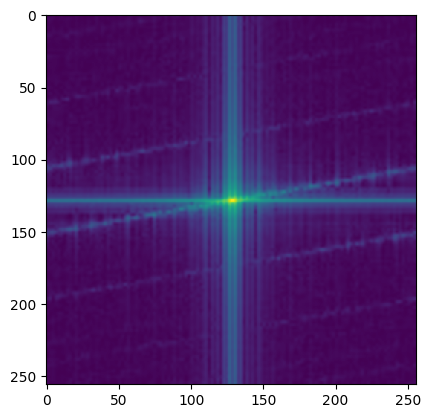

In [ ]:
def create_paths(filenames, directory):
  file_paths = [os.path.join(directory, filename) for filename in filenames]
  return file_paths

training_data_paths = create_paths(training_data_filenames, training_data_dir)

def load_fft(image_path, size=(256,256)):
  image = tf.io.read_file(image_path)
  image = tf.image.decode_png(image, 1)
  image = tf.image.resize(image, size)
  image = tf.cast(image, tf.float32) / 255.0
  return image

#Visualise FFT Image
index = 2900
final = load_fft(training_data_paths[index])
print(training_data_paths[index])

final_fft_array = final.numpy()
plt.imshow(final_fft_array)
print(np.shape(final_fft_array))

In [ ]:
print(training_data_paths)

['/content/drive/MyDrive/train_stiv_fft/stiv_fft_101_18.jpg', '/content/drive/MyDrive/train_stiv_fft/stiv_fft_104_57.jpg', '/content/drive/MyDrive/train_stiv_fft/stiv_fft_92_92.jpg', '/content/drive/MyDrive/train_stiv_fft/stiv_fft_114_83.jpg', '/content/drive/MyDrive/train_stiv_fft/stiv_fft_100_59.jpg', '/content/drive/MyDrive/train_stiv_fft/stiv_fft_110_48.jpg', '/content/drive/MyDrive/train_stiv_fft/stiv_fft_92_0.jpg', '/content/drive/MyDrive/train_stiv_fft/stiv_fft_113_79.jpg', '/content/drive/MyDrive/train_stiv_fft/stiv_fft_107_47.jpg', '/content/drive/MyDrive/train_stiv_fft/stiv_fft_114_49.jpg', '/content/drive/MyDrive/train_stiv_fft/stiv_fft_104_31.jpg', '/content/drive/MyDrive/train_stiv_fft/stiv_fft_111_38.jpg', '/content/drive/MyDrive/train_stiv_fft/stiv_fft_102_11.jpg', '/content/drive/MyDrive/train_stiv_fft/stiv_fft_91_4.jpg', '/content/drive/MyDrive/train_stiv_fft/stiv_fft_90_73.jpg', '/content/drive/MyDrive/train_stiv_fft/stiv_fft_103_69.jpg', '/content/drive/MyDrive/train

In [ ]:
x_train_tensor = tf.data.Dataset.from_tensor_slices(training_data_paths)
x_train = x_train_tensor.map(load_fft)
y_train = tf.data.Dataset.from_tensor_slices(onehot_encoded)
training_data = tf.data.Dataset.zip(x_train, y_train)

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, LeakyReLU, Dense, Flatten
from keras_cv.layers import DropBlock2D
from keras.models import Model


def STIV_CNN(input_size=(256,256,1), kernel_init='he_normal', drop_rate=0.1, block_size=7):
  inputs = Input(input_size)
  conv1 = Conv2D(32, kernel_size=(7,7), activation=LeakyReLU(alpha=0.3), kernel_initializer=kernel_init)(inputs)
  conv2 = Conv2D(32, kernel_size=(5,5), activation=LeakyReLU(alpha=0.3), kernel_initializer=kernel_init)(conv1)
  pool1 = MaxPooling2D((2,2))(conv2)
  dropblock1 = DropBlock2D(drop_rate, block_size)(pool1)

  conv3 = Conv2D(64, kernel_size=(5,5), activation=LeakyReLU(alpha=0.3), kernel_initializer=kernel_init)(dropblock1)
  conv4 = Conv2D(64, kernel_size=(3,3), activation=LeakyReLU(alpha=0.3), kernel_initializer=kernel_init)(conv3)
  pool2 = MaxPooling2D((2,2))(conv4)
  dropblock2 = DropBlock2D(drop_rate, block_size)(pool2)

  conv5 = Conv2D(128, kernel_size=(5,5), activation=LeakyReLU(alpha=0.3), kernel_initializer=kernel_init)(dropblock2)
  conv6 = Conv2D(128, kernel_size=(3,3), activation=LeakyReLU(alpha=0.3), kernel_initializer=kernel_init)(conv5)
  pool3 = MaxPooling2D((2,2))(conv6)
  dropblock3 = DropBlock2D(drop_rate, block_size)(pool3)

  conv7 = Conv2D(512, kernel_size=(5,5), activation=LeakyReLU(alpha=0.3), kernel_initializer=kernel_init)(dropblock3)
  conv8 = Conv2D(512, kernel_size=(3,3), activation=LeakyReLU(alpha=0.3), kernel_initializer=kernel_init)(conv7)
  global_avg_pool = GlobalAveragePooling2D()(conv8)

  flatten = Flatten()(global_avg_pool)
  out_layer = Dense(30, activation ='softmax', kernel_initializer=kernel_init)(flatten)

  return Model(inputs=[inputs], outputs=[out_layer])

Using TensorFlow backend


In [ ]:
from keras.optimizers import Adam
tf.config.run_functions_eagerly(True)
model = STIV_CNN()
model.compile(optimizer= Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 250, 250, 32)      1600      
                                                                 
 conv2d_1 (Conv2D)           (None, 246, 246, 32)      25632     
                                                                 
 max_pooling2d (MaxPooling2  (None, 123, 123, 32)      0         
 D)                                                              
                                                                 
 drop_block2d (DropBlock2D)  (None, 123, 123, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 119, 119, 64)      51264     
                                                             

In [ ]:
#Batch Data
batch_size = 32
train_data = training_data.batch(batch_size)
train_hist = model.fit(train_data, epochs=30)

Epoch 1/30
94/94 [==============================] - 674s 7s/step - loss: 3.3247 - categorical_accuracy: 0.0554
Epoch 2/30
94/94 [==============================] - 16s 174ms/step - loss: 3.1543 - categorical_accuracy: 0.0869
Epoch 3/30
94/94 [==============================] - 16s 173ms/step - loss: 2.6424 - categorical_accuracy: 0.1523
Epoch 4/30
94/94 [==============================] - 16s 172ms/step - loss: 2.0273 - categorical_accuracy: 0.2658
Epoch 5/30
94/94 [==============================] - 18s 191ms/step - loss: 1.6474 - categorical_accuracy: 0.3691
Epoch 6/30
94/94 [==============================] - 17s 179ms/step - loss: 1.2574 - categorical_accuracy: 0.5067
Epoch 7/30
94/94 [==============================] - 16s 173ms/step - loss: 0.9154 - categorical_accuracy: 0.6473
Epoch 8/30
94/94 [==============================] - 16s 173ms/step - loss: 0.6277 - categorical_accuracy: 0.7674
Epoch 9/30
94/94 [==============================] - 16s 174ms/step - loss: 0.4027 - categorical_ac

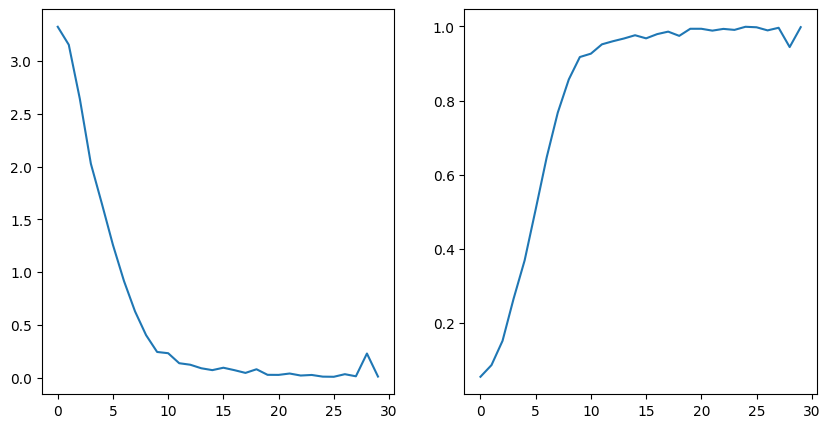

In [ ]:
#Training Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(train_hist.history['loss'], '-', label = 'Loss')
ax2.plot(train_hist.history['categorical_accuracy'], label='Accuracy')